In [11]:
%load_ext autoreload
%autoreload 3
from common import preprocess, read_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from scipy import interpolate
from imblearn.over_sampling import SMOTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
loans = read_data()
print("Total incoming", len(loans))
processed = preprocess(loans, keep_percent=0.1)
print("Length of processed", len(processed))

approved = np.array(processed["approved"])
gender = np.array(processed["applicant_sex"])
race = np.array(processed["applicant_race"])
X_unsampled = processed.drop(["approved", "applicant_sex", "applicant_race"], axis=1)
total_columns = len(X_unsampled.columns)
print("Total columns", total_columns)

Total incoming 1714459
Length of processed 98762
Total columns 19


In [13]:

output_dim = 1
loss_fn = nn.BCELoss()
y_unsampled = gender

print("Using Binary Cross Entropy")
def calc_loss(output, labels):
    return loss_fn(output, labels.reshape(-1,1))

def calc_accurracy(outputs, labels):
    acc = sum(
        outputs.clone().cpu().reshape(-1).detach().numpy().round() == labels.clone().cpu().numpy()
    ) / len(outputs)
    return acc

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X_unsampled, y_unsampled)

X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_tv, y_tv, test_size=0.60, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)

Using Binary Cross Entropy


In [25]:
loans["action_taken"].value_counts()

1    877753
4    241369
6    233447
3    226258
5     81948
2     53535
7        80
8        69
Name: action_taken, dtype: int64

In [15]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class LoanDataset(Dataset):

    def __init__(self, x, y):

        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

dataset = LoanDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset = LoanDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset = LoanDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset, batch_size=100, shuffle=False)
del dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

input_dim = total_columns
learning_rate = 0.005

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p=0.05)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(self.relu(self.hidden2(x)))
        x = self.dropout(self.relu(self.hidden3(x)))
        x = self.sigmoid(self.output(x))
        return x

model = NeuralNetwork().to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 500
loss_values = []
acc_values = []

losses = []
all_accs = []
val_accs = []
for i in range(num_epochs):
    model.train(True)
    accs = []
    for j, (xinputs, ylabels) in enumerate(train_loader):

        xinputs, ylabels = xinputs.to(device), ylabels.to(device)

        #calculate output
        output = model(xinputs)

        #calculate loss
        # loss = loss_fn(output, ylabels.reshape(-1,1))
        loss = calc_loss(output, ylabels)

        # calc accuracy
        accs.append(calc_accurracy(output, ylabels))

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc_epoch = sum(accs)/len(accs)

    # Calculate validation
    model.train(False)
    vacc = 0
    for k, (vinputs, vlabels) in enumerate(valid_loader):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = calc_loss(voutputs, vlabels)
        vacc += calc_accurracy(voutputs, vlabels)

    vacc_epoch = vacc/k

    losses.append(float(loss))
    all_accs.append(acc_epoch)
    val_accs.append(vacc_epoch)
    print("epoch {}\tloss : {}\tacc: {}".format(i, loss, acc_epoch))
    print("epoch {}\tvloss : {}\tvacc: {}\n".format(i, vloss, vacc_epoch))

print("Training Complete")


Using cuda device
NeuralNetwork(
  (hidden1): Linear(in_features=19, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
epoch 0	loss : 0.8040595650672913	acc: 0.6366843180973618
epoch 0	vloss : 0.6009343862533569	vacc: 0.6537561663143057

epoch 1	loss : 0.6619210243225098	acc: 0.6592818654775172
epoch 1	vloss : 0.595054030418396	vacc: 0.6627709654686393

epoch 2	loss : 0.6523198485374451	acc: 0.6649860646599784
epoch 2	vloss : 0.5564501285552979	vacc: 0.6668717406624379

epoch 3	loss : 0.5903614163398743	acc: 0.6699340393905611
epoch 3	vloss : 0.5519194602966309	vacc: 0.6715687103594071

epoch 4	loss : 0.5720861554145813	acc: 0.6722528799702708
epoch 4	vloss : 0.5434225797653198	vacc: 0.6694122621564471

epoch 5	loss : 0.55367332696914

KeyboardInterrupt: 

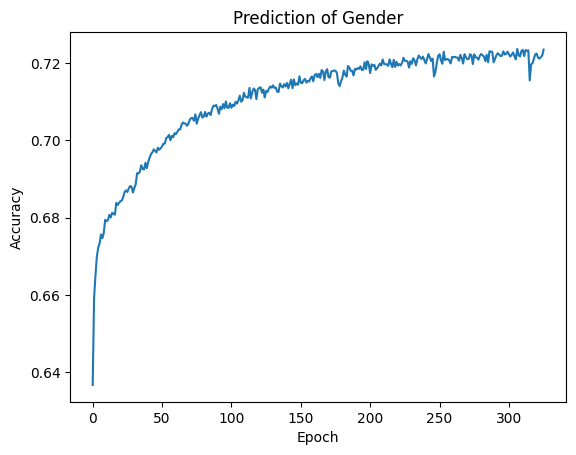

In [16]:
plt.plot(all_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Prediction of Gender")

plt.show()

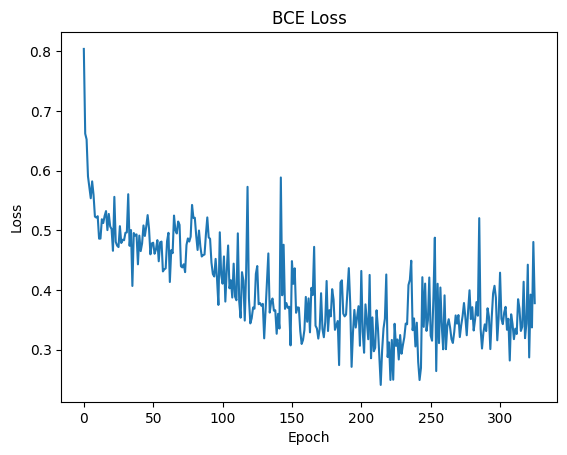

In [17]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BCE Loss")
plt.show()